<a href="https://colab.research.google.com/github/rayxuan2000/Project/blob/main/Supervised_Learning_CTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In this project, I will implemented data analysis on a ad click through rate dataset which contains EDA, model training and result evaluation.**

# **Preparation**

In [505]:
# pip install dask[dataframe] --upgrade

In [506]:
import pandas as pd
import numpy as np
import dask.dataframe as dask_data

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs

from sklearn.metrics import roc_curve
from sklearn import metrics
import sklearn
import matplotlib.dates as mdates
from sklearn.metrics import classification_report,confusion_matrix
matplotlib.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


#A parse date variable to pass in the read_csv function later to take into account the date format
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [507]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Data EDA**

### train_data - original data

In [508]:
# A sample dataset of 100k lines.
!ls '/content/drive/My Drive/train_data'

train_data = pd.read_csv('/content/drive/My Drive/train_data/filtered_train.csv', parse_dates = ['hour'], date_parser = parse_date, nrows = 100000)

train_data.info()

train_data_clicks = train_data[train_data['click']==1]

filtered_train.csv


<ipython-input-506-ff1ce306495f>:22: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        100000 non-null  int64         
 1   id                100000 non-null  float64       
 2   click             100000 non-null  int64         
 3   hour              100000 non-null  datetime64[ns]
 4   C1                100000 non-null  int64         
 5   banner_pos        100000 non-null  int64         
 6   site_id           100000 non-null  object        
 7   site_domain       100000 non-null  object        
 8   site_category     100000 non-null  object        
 9   app_id            100000 non-null  object        
 10  app_domain        100000 non-null  object        
 11  app_category      100000 non-null  object        
 12  device_id         100000 non-null  object        
 13  device_ip         100000 non-null  object        
 14  devic

In [509]:
train_data.describe()

,Unnamed: 0,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.999950e+06,9.213280e+18,0.166530,1004.982610,0.256050,1.017630,0.241970,18490.707470,317.961280,59.130140,2083.369360,1.315670,177.618200,49145.389770,93.558420
std,2.886543e+06,5.333749e+18,0.372558,1.000549,0.459272,0.489961,0.707662,4857.861307,25.627016,47.026765,592.502179,1.380312,324.085017,50047.403239,67.464087
min,2.430000e+02,3.844055e+14,0.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,216.000000,36.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,2.497934e+06,4.575126e+18,0.000000,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,33.000000
50%,5.000052e+06,9.223103e+18,0.000000,1005.000000,0.000000,1.000000,0.000000,20352.000000,320.000000,50.000000,2333.000000,0.000000,39.000000,-1.000000,79.000000
75%,7.497899e+06,1.382401e+19,0.000000,1005.000000,1.000000,1.000000,0.000000,21759.000000,320.000000,50.000000,2502.000000,3.000000,167.000000,100084.000000,157.000000
max,9.999860e+06,1.844648e+19,1.000000,1012.000000,7.000000,5.000000,5.000000,22118.000000,1024.000000,1024.000000,2547.000000,3.000000,1835.000000,100248.000000,221.000000


data fields:

id: ad identifier

click: 0/1 for non-click/click

hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.

C1 -- anonymized categorical variable

C14-C21 -- anonymized categorical variables

In [510]:
train_data.head()

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,128037,1.107451e+19,0,2014-10-21 01:00:00,1005,1,e151e245,7e091613,f028772b,ecad2386,...,1,0,20352,320,50,2333,0,39,-1,157
1,491755,1.240012e+19,0,2014-10-21 03:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15701,320,50,1722,0,35,100084,79
2,470924,1.059801e+19,0,2014-10-21 03:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,1,0,17614,320,50,1993,2,1063,-1,33
3,791624,1.844219e+18,0,2014-10-21 04:00:00,1005,1,856e6d3f,58a89a43,f028772b,ecad2386,...,1,0,16208,320,50,1800,3,167,100075,23
4,491263,1.236016e+19,1,2014-10-21 03:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,...,1,0,17614,320,50,1993,2,1063,-1,33


0    0.83347
1    0.16653
Name: click, dtype: float64

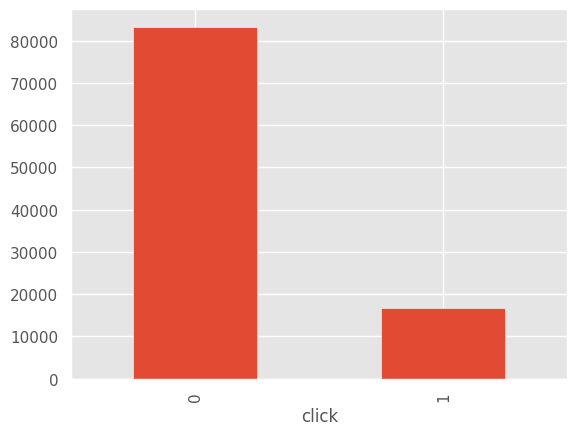

In [511]:
# Click v/s No click distribution
train_data.groupby('click').size().plot(kind = 'bar')
rows = train_data.shape[0]
click_through_rate = train_data['click'].value_counts()/rows
click_through_rate

In [512]:
# hour
train_data.hour.describe()

<ipython-input-512-b7f75bc7a47b>:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  100000
unique                     53
top       2014-10-22 09:00:00
freq                     4457
first     2014-10-21 00:00:00
last      2014-10-23 04:00:00
Name: hour, dtype: object

In [513]:
train_data['hour'].describe()

<ipython-input-513-6aee87be80ef>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  100000
unique                     53
top       2014-10-22 09:00:00
freq                     4457
first     2014-10-21 00:00:00
last      2014-10-23 04:00:00
Name: hour, dtype: object

In [514]:
# banner position
"""Banner positions representing attractive and appealing designs that might highly
affect a user's behavior and in turn trigger their decision to click or not.
Hence making it an effective metric to predict clicks"""
train_data['banner_pos'].unique()

array([1, 0, 5, 2, 7, 4])

<Axes: title={'center': 'banner positions v.s. clicks'}, xlabel='banner_pos'>

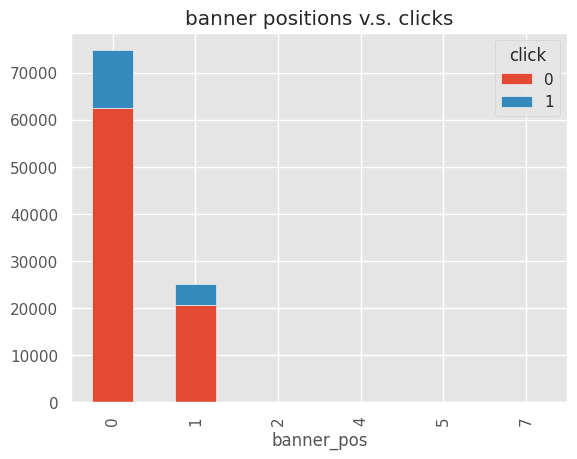

In [515]:
# banner position & click relation
banner_temp =train_data[['banner_pos','click']].groupby(['banner_pos','click'])

banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions v.s. clicks')

In [516]:
train_data[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,74775
1,25115
5,38
2,30
7,24
4,18


In [517]:
# click percent for each banner position
banner_df = pd.DataFrame()
banner_df['position'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['banner_pos']
banner_df['pos_clicks'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
banner_df['total_impressions'] = train_data[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
banner_df['click_pct'] = 100*banner_df['pos_clicks']/banner_df['total_impressions']
banner_df

,position,pos_clicks,total_impressions,click_pct
0,0,12209,74775,16.327650
1,1,4424,25115,17.614971
5,7,12,24,50.000000
2,2,4,30,13.333333
4,5,3,38,7.894737
3,4,1,18,5.555556


In [518]:
banner_df.sort_values(ascending=False,by='click_pct')

,position,pos_clicks,total_impressions,click_pct
5,7,12,24,50.000000
1,1,4424,25115,17.614971
0,0,12209,74775,16.327650
2,2,4,30,13.333333
4,5,3,38,7.894737
3,4,1,18,5.555556


<Axes: title={'center': 'device types'}, xlabel='device_type'>

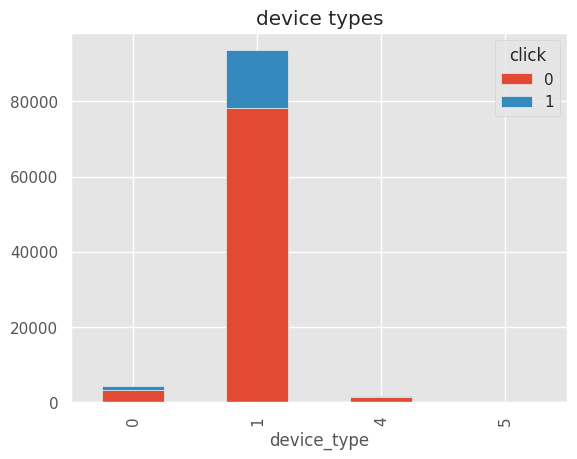

In [519]:
# Device type & click relation
device_temp = train_data[['device_type','click']].groupby(['device_type','click'])
device_temp.size().unstack().plot(kind='bar',stacked=True, title='device types')

In [520]:
train_data[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,93583
0,4435
4,1730
5,252


<Axes: title={'center': 'device types'}, xlabel='device_type'>

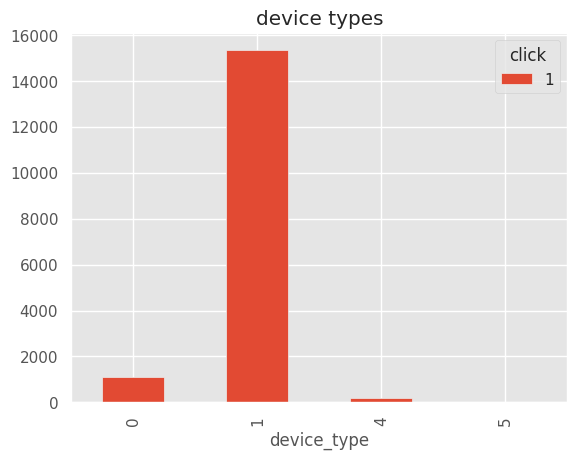

In [521]:
train_data_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')

In [522]:
# click percent for each device type
dev_type_df = train_data_clicks.groupby('device_type').agg({'click':'sum'}).reset_index()
dev_type_df_total_imp = train_data.groupby('device_type').agg({'click':'count'}).reset_index()
dev_type_df['total_impressions'] = dev_type_df_total_imp['click']
dev_type_df['success_pct'] = (dev_type_df['click']/dev_type_df['total_impressions'])*100
dev_type_df

,device_type,click,total_impressions,success_pct
0,0,1110,4435,25.028185
1,1,15333,93583,16.384386
2,4,187,1730,10.809249
3,5,23,252,9.126984


In [523]:
# App category and click relation
app_features = ['app_id', 'app_domain', 'app_category']
train_data.groupby('app_category').agg({'click':'sum'}).sort_values(by='click',ascending = False)

,click
app_category,
07d7df22,11818
0f2161f8,3183
cef3e649,756
f95efa07,520
8ded1f7a,237
09481d60,79
d1327cf5,25
dc97ec06,11
75d80bbe,7


<Axes: title={'center': 'Intra-category CTR'}, xlabel='app_category'>

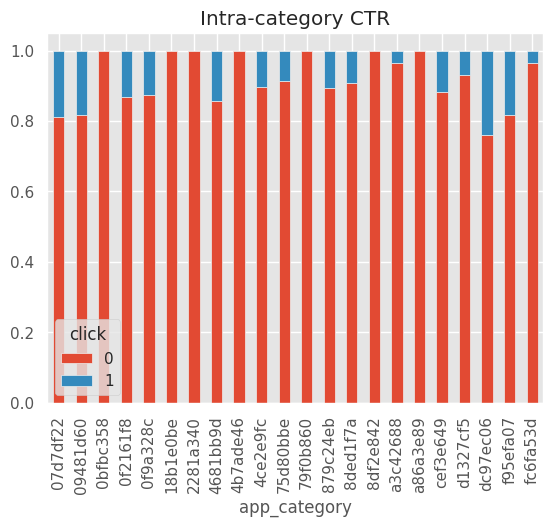

In [524]:
# Clicks behavior across different app categories
train_app_category = train_data.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

In [525]:
# C1, C14-C21 features
features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18',
            'C20', 'C21']
train_data[features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C20,C21
count,100000,100000,100000,100000,100000,100000,100000,100000
unique,7,741,7,8,205,4,157,41
top,1005,21767,320,50,1722,0,-1,157
freq,93188,3776,93074,93506,10705,50316,50908,16374


<Axes: title={'center': 'C1 histogram'}, xlabel='C18'>

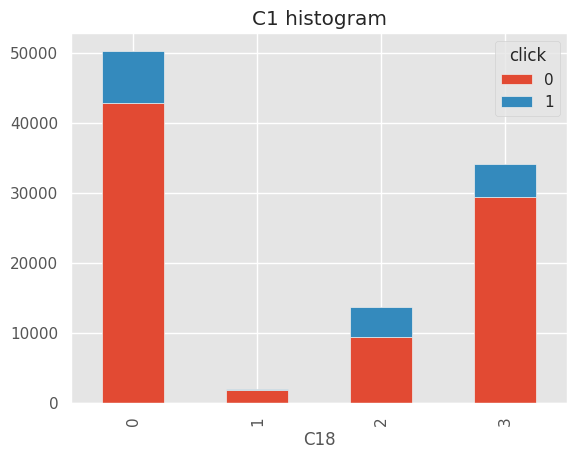

In [526]:
# train_data.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
# train_data.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
# train_data.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')

# **Model Training and Evaluation**

## Feature Selection and Encoding

### train_model_ori is whole data with label to be trained and tested

In [527]:
# select features
model_features = ['banner_pos', 'site_category', 'device_conn_type', 'app_category','device_type', 'C14', 'C17']
model_target = 'click'
train_model_ori = train_data[model_features+[model_target]].sample(frac=0.1)

In [528]:
train_model_ori.head()

,banner_pos,site_category,device_conn_type,app_category,device_type,C14,C17,click
75247,1,50e219e0,3,0f2161f8,4,15701,1722,0
63667,1,28905ebd,2,07d7df22,1,15705,1722,0
62270,1,f028772b,0,07d7df22,1,21894,2526,0
91735,0,3e814130,0,07d7df22,1,20352,2333,0
66161,0,50e219e0,0,0f2161f8,1,21767,2506,0


In [529]:
train_model_ori.shape

(10000, 8)

In [530]:
train_model_ori.head()

,banner_pos,site_category,device_conn_type,app_category,device_type,C14,C17,click
75247,1,50e219e0,3,0f2161f8,4,15701,1722,0
63667,1,28905ebd,2,07d7df22,1,15705,1722,0
62270,1,f028772b,0,07d7df22,1,21894,2526,0
91735,0,3e814130,0,07d7df22,1,20352,2333,0
66161,0,50e219e0,0,0f2161f8,1,21767,2506,0


In [531]:
# categorical feature encoding
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                    columns = feature_set,
                                    sparse = True)

    return new_data_frame

### train_model is encoded whole data

In [532]:
train_model = one_hot_features(train_model_ori,
                                ['site_category',
                                 'app_category',
                                 'banner_pos'])
train_model.head()

,device_conn_type,device_type,C14,C17,click,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_50e219e0,...,app_category_d1327cf5,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_4,banner_pos_5,banner_pos_7
75247,3,4,15701,1722,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
63667,2,1,15705,1722,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
62270,0,1,21894,2526,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
91735,0,1,20352,2333,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
66161,0,1,21767,2506,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [533]:
train_model.shape

(10000, 43)

## Train and test set split

In [534]:
# Extracting all columns from the train model except the target mask column
# model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

In [535]:
# train test split
from sklearn.model_selection import train_test_split
from sklearn import model_selection
# x_train, x_test, y_train, y_test = train_test_split(
#     train_model[model_features].values,
#     train_model[model_target].values,
#     test_size=0.3,
# )

In [536]:
x = train_model.drop(labels=['click'],axis=1, index=None, columns=None, inplace=False)
y = train_model['click']
x_train, x_test, y_train, y_test = \
model_selection.train_test_split(x, y, test_size=0.25, stratify = y, random_state = 42)
print('training data has ' + str(x_train.shape[0]) + \
      ' observation with ' + str(x_train.shape[1]) + ' features')
print('test data has ' + str(x_test.shape[0]) + \
      ' observation with ' + str(x_test.shape[1]) + ' features')

training data has 7500 observation with 42 features
test data has 2500 observation with 42 features


In [537]:
x_train

,device_conn_type,device_type,C14,C17,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_50e219e0,site_category_70fb0e29,...,app_category_d1327cf5,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_4,banner_pos_5,banner_pos_7
24368,0,0,21590,2478,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
91587,0,1,21611,2480,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
31469,0,4,21790,2513,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
64280,0,1,21768,2506,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
61414,0,1,20312,1780,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92888,0,1,17239,1973,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
97263,0,1,21611,2480,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
6206,0,1,15706,1722,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
71993,2,1,21767,2506,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [538]:
from sklearn.preprocessing import StandardScaler

temp = train_model_ori.drop(['banner_pos','click'], axis='columns')
num_cols = temp.columns[temp.dtypes != 'object']
num_cols

Index(['device_conn_type', 'device_type', 'C14', 'C17'], dtype='object')

In [539]:
scaler = StandardScaler()
scaler.fit(train_model[num_cols])

x_train[num_cols] = scaler.transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

In [540]:
x_train.head()

,device_conn_type,device_type,C14,C17,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_50e219e0,site_category_70fb0e29,...,app_category_d1327cf5,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_4,banner_pos_5,banner_pos_7
24368,-0.34748,-2.037961,0.634911,0.662970,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
91587,-0.34748,-0.042894,0.639236,0.666352,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
31469,-0.34748,5.942308,0.676094,0.722149,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
64280,-0.34748,-0.042894,0.671564,0.710313,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
61414,-0.34748,-0.042894,0.371757,-0.517228,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Model Training

In [541]:
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [542]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score

# F1 score used as a performance metric
num_splits = 3
c_values = np.logspace(-2, 0, 5)
# stratified k-fold
stratified_k_fold = StratifiedKFold(n_splits=num_splits)
scores = np.zeros(5)
nr_params = np.zeros(5)

## Logistic Regression

In [543]:
# for train_data, valid_data in stratified_k_fold.split(x_train,
#                                                       y_train):
#     for i, c in enumerate(np.logspace(-2, 0, 5)):
#         lr_classify = LogisticRegression(penalty='l2',
#                                          class_weight='balanced',
#                                          C = c, max_iter=1000)
#         lr_classify.fit(x_train[train_data],
#                         y_train[train_data])

#         #validation_Set evaluation

#         y_prediction = lr_classify.predict(x_train[valid_data])
#         score_f1 = f1_score(y_train[valid_data],
#                             y_prediction, average='weighted' )

#         scores[i] += score_f1 / num_splits

#         ### spot the selected parameters ##

#         model_selected = SelectFromModel(lr_classify, prefit=True)
#         nr_params[i] += np.sum(model_selected.get_support()) / num_splits

In [544]:
# plt.figure(figsize=(10, 5))
# plt.plot(nr_params, scores)

# for i, c in enumerate(c_values):
#     plt.annotate(c, (nr_params[i], scores[i]))
# plt.xlabel("Nr of parameters")
# plt.ylabel("Avg F1 score")

In [545]:
parameters = {
    'penalty':('l2','l1'),
    'C':(0.01, 0.05, 0.1, 0.2, 0.5)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv = 10)
Grid_LR.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse colu

GridSearchCV(cv=10, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.01, 0.05, 0.1, 0.2, 0.5),
                         'penalty': ('l2', 'l1')})

In [546]:
print_grid_search_metrics(Grid_LR)

Best score: 0.8318666666666665
Best parameters set:
C:0.01
penalty:l2


In [547]:
best_LR_model = Grid_LR.best_estimator_

In [548]:
best_LR_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



array([0, 0, 0, ..., 0, 0, 0])

In [549]:
cm_LR_CV= confusion_matrix(y_test, best_LR_model.predict(x_test))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



## KNN

In [550]:
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier()

# Choose k
parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=10)
Grid_KNN.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse colu

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]})

In [551]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.8208
Best parameters set:
n_neighbors:7


In [552]:
best_KNN_model = Grid_KNN.best_estimator_

In [553]:
best_KNN_model.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



array([0, 0, 0, ..., 0, 0, 0])

In [554]:
cm_KNN_CV= confusion_matrix(y_test, best_KNN_model.predict(x_test))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



## Random Forest

In [555]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier()

# Choose the number of trees
parameters = {
    'n_estimators' : [20,40,60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=10)
Grid_RF.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse colu

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [20, 40, 60, 80, 100]})

In [556]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8342666666666668
Best parameters set:
max_depth:10
n_estimators:20


In [557]:
best_RF_model = Grid_RF.best_estimator_

In [558]:
cm_RF_CV= confusion_matrix(y_test, best_RF_model.predict(x_test))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



## XGBoost

In [559]:
# XGBoost classifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    stratify=y_train,
    test_size=0.1)

xgb_clf = XGBClassifier()

xgb_clf.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="logloss", eval_set=[(x_valid, y_valid)])

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-logloss:0.44247
[1]	validation_0-logloss:0.43436
[2]	validation_0-logloss:0.42871
[3]	validation_0-logloss:0.42683
[4]	validation_0-logloss:0.42604
[5]	validation_0-logloss:0.42522
[6]	validation_0-logloss:0.42632
[7]	validation_0-logloss:0.42661
[8]	validation_0-logloss:0.42678
[9]	validation_0-logloss:0.42736
[10]	validation_0-logloss:0.42800
[11]	validation_0-logloss:0.42803
[12]	validation_0-logloss:0.42886
[13]	validation_0-logloss:0.42907
[14]	validation_0-logloss:0.42894
[15]	validation_0-logloss:0.42851


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [560]:
y_pred = xgb_clf.predict(x_test)
predictions = [round(value) for value in y_pred]
print(classification_report(y_test,
                            predictions))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2080
           1       0.50      0.02      0.04       420

    accuracy                           0.83      2500
   macro avg       0.67      0.51      0.47      2500
weighted avg       0.78      0.83      0.76      2500



## Compare different best models

In [561]:
def print_classification_report(model):
  prediction = model.predict(x_test)
  print(classification_report(y_test,prediction))

def plot_confusion_matrix(cm, model,title):
  sns.set()
  f,ax=plt.subplots()
  prediction = model.predict(x_test)
  sns.heatmap(cm,annot=True,ax=ax,fmt='.20g',xticklabels=['No','Yes'],yticklabels=['No','Yes'])
  ax.set_title('confusion matrix')
  ax.set_xlabel('predict')
  ax.set_ylabel('true')
  ax.set_title(title[i])

RF
  
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2080
           1       0.48      0.04      0.07       420

    accuracy                           0.83      2500
   macro avg       0.66      0.51      0.49      2500
weighted avg       0.78      0.83      0.77      2500

KNN
  


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2080
           1       0.38      0.14      0.21       420

    accuracy                           0.82      2500
   macro avg       0.62      0.55      0.55      2500
weighted avg       0.77      0.82      0.78      2500

LR
  
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2080
           1       0.00      0.00      0.00       420

    accuracy                           0.83      2500
   macro avg       0.42      0.50      0.45      2500
weighted avg       0.69      0.83      0.76      2500

  


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



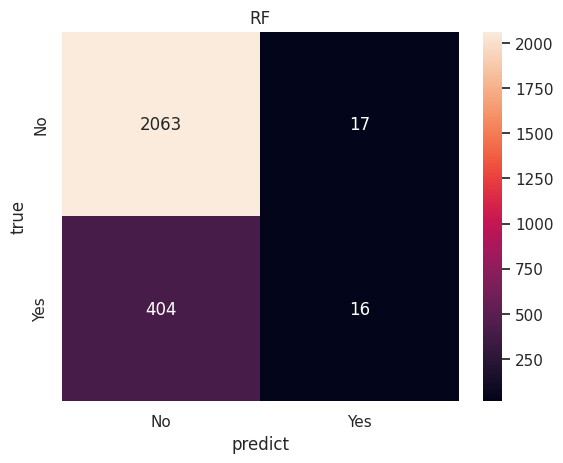

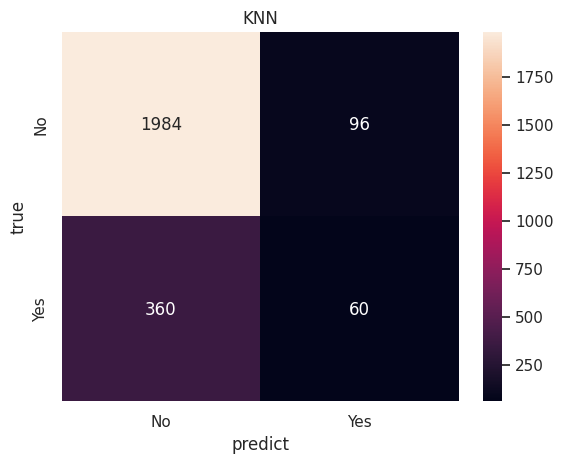

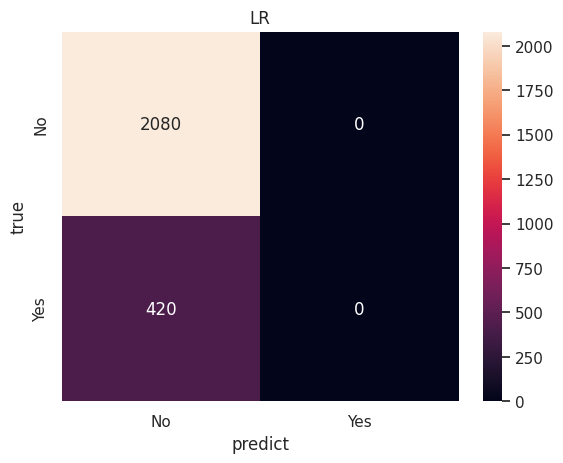

In [562]:
#best_RF_model, best_KNN_model, best_LR_model
cm_lst=[cm_RF_CV,cm_KNN_CV,cm_LR_CV]
model_lst=[best_RF_model,best_KNN_model,best_LR_model]
title=['RF','KNN','LR']

for i in range(len(cm_lst)):
  print(title[i])
  print("  ")
  print_classification_report(model_lst[i])

for i in range(len(cm_lst)):
  plot_confusion_matrix(cm_lst[i],model_lst[i],title)
  print("  ")